In [19]:
import math
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F
from torchvision.utils import make_grid
import torchsummary

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Prepare Data
# CIFAR-10
batch_size = 32
    
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((32, 32), antialias=True),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomResizedCrop((32, 32), antialias=True, scale=(0.8, 1.0), ratio=(0.75, 1.33), interpolation=2)
    ])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((32, 32), antialias=True)
    ])

train_set = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform_train)

train_loader = torch.utils.data.DataLoader(train_set, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform_test)

test_loader = torch.utils.data.DataLoader(test_set, 
                                         batch_size=batch_size,
                                         shuffle=False, 
                                         num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


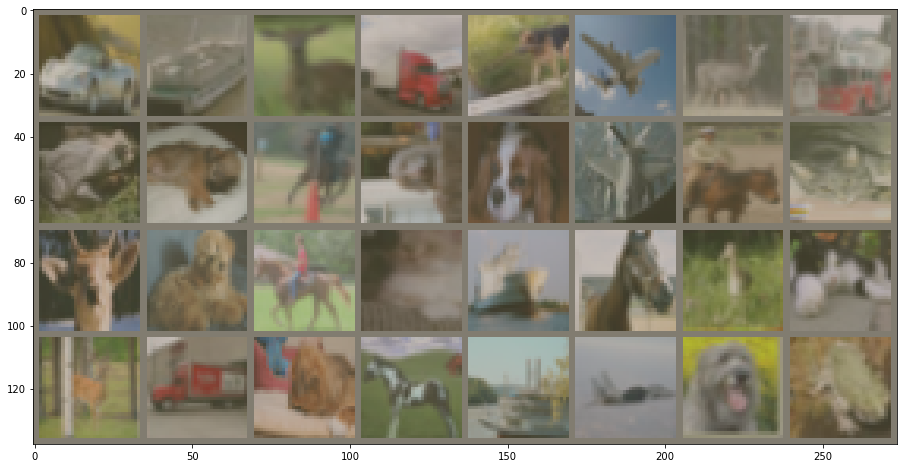

tensor([1, 8, 4, 9, 5, 0, 4, 9, 6, 5, 7, 5, 5, 0, 7, 3, 4, 5, 7, 3, 8, 7, 2, 3,
        4, 9, 5, 7, 8, 0, 5, 6])


In [4]:
# Function to show images
def show_img(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.507, 0.487, 0.441])
    std = np.array([0.267, 0.256, 0.276])
    img = mean + img * std # Unnormalize
    plt.figure(figsize=(16, 8))
    plt.imshow((255 * img).astype(int))  # Convert from tensor image
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
show_img(make_grid(images[:32]))
print(labels[:32])

In [5]:
class GeLU(nn.Module):
    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class PatchEmbeddings(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.image_size = args["image_size"]
        self.patch_size = args["patch_size"]
        self.num_channels = args["num_channels"]
        self.hidden_size = args["hidden_size"]
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class Embeddings(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.patch_embeddings = PatchEmbeddings(args)
        self.cls_token = nn.Parameter(torch.randn(1, 1, args["hidden_size"]))
        self.position_embeddings = nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, args["hidden_size"]))
        self.dropout = nn.Dropout(args["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x


class AttentionHead(nn.Module):

    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


class MultiHeadAttention(nn.Module):

    def __init__(self, args):
        super().__init__()
        self.hidden_size = args["hidden_size"]
        self.num_attention_heads = args["num_attention_heads"]
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.qkv_bias = args["qkv_bias"]
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                args["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(args["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        attention_outputs = [head(x) for head in self.heads]
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


class FasterMultiHeadAttention(nn.Module):

    def __init__(self, args):
        super().__init__()
        self.hidden_size = args["hidden_size"]
        self.num_attention_heads = args["num_attention_heads"]
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.qkv_bias = args["qkv_bias"]
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(args["attention_probs_dropout_prob"])
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(args["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        qkv = self.qkv_projection(x)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)
        attention_output = torch.matmul(attention_probs, value)
        attention_output = attention_output.transpose(1, 2) \
                                           .contiguous() \
                                           .view(batch_size, sequence_length, self.all_head_size)
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)


class MLP(nn.Module):

    def __init__(self, args):
        super().__init__()
        self.dense_1 = nn.Linear(args["hidden_size"], args["intermediate_size"])
        self.activation = GeLU()
        self.dense_2 = nn.Linear(args["intermediate_size"], args["hidden_size"])
        self.dropout = nn.Dropout(args["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):

    def __init__(self, args):
        super().__init__()
        self.use_faster_attention = args.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(args)
        else:
            self.attention = MultiHeadAttention(args)
        self.layernorm_1 = nn.LayerNorm(args["hidden_size"])
        self.mlp = MLP(args)
        self.layernorm_2 = nn.LayerNorm(args["hidden_size"])

    def forward(self, x, output_attentions=False):
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        x = x + attention_output
        mlp_output = self.mlp(self.layernorm_2(x))
        x = x + mlp_output
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


class Encoder(nn.Module):

    def __init__(self, args):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(args["num_hidden_layers"]):
            block = Block(args)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)


class ViTForClassfication(nn.Module):

    def __init__(self, args):
        super().__init__()
        self.args = args
        self.image_size = args["image_size"]
        self.hidden_size = args["hidden_size"]
        self.num_classes = args["num_classes"]
        self.embedding = Embeddings(args)
        self.encoder = Encoder(args)
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        embedding_output = self.embedding(x)
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        logits = self.classifier(encoder_output[:, 0, :])
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.args["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.args["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.args["initializer_range"],
            ).to(module.cls_token.dtype)

In [14]:
args = {
    # 32x32 -> 8x8 patches
    "patch_size": 4,
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10,
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}

In [21]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

119098

In [41]:
batch_size = 32
epochs = 100
lr = 1e-2
device = "cuda" if torch.cuda.is_available() else "cpu"

args = {
    # 32x32 -> 8x8 patches
    "patch_size": 4,
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10,
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}

model = ViTForClassfication(args)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
loss_cal = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accs = []
test_accs = []

def train_epoch(train_loader):
        model.train()
        total_loss = 0
        correct = 0
        total_samples = 0
        for batch in train_loader:
            batch = [t.to(device) for t in batch]
            images, labels = batch
            optimizer.zero_grad()
            logits = model(images)[0]
            loss = loss_cal(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
            total_samples += len(labels)
        train_accuracy = correct / total_samples
        avg_loss = total_loss / total_samples
        return avg_loss, train_accuracy


@torch.no_grad()
def evaluate(test_loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = [t.to(device) for t in batch]
            images, labels = batch

            logits, _ = model(images)

            loss = loss_cal(logits, labels)
            total_loss += loss.item() * len(images)

            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
    accuracy = correct / len(test_loader.dataset)
    avg_loss = total_loss / len(test_loader.dataset)
    return avg_loss, accuracy

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(train_loader)
    test_loss, test_acc = evaluate(test_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f"Epoch: {epoch+1}, Train loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch: 1, Train loss: 1.9421, Train Accuracy: 0.2694, Test loss: 1.7051, Test Accuracy: 0.3692
Epoch: 2, Train loss: 1.5942, Train Accuracy: 0.4140, Test loss: 1.4867, Test Accuracy: 0.4616
Epoch: 3, Train loss: 1.4699, Train Accuracy: 0.4597, Test loss: 1.4099, Test Accuracy: 0.4895
Epoch: 4, Train loss: 1.4064, Train Accuracy: 0.4906, Test loss: 1.4450, Test Accuracy: 0.4765
Epoch: 5, Train loss: 1.3706, Train Accuracy: 0.5010, Test loss: 1.3121, Test Accuracy: 0.5242
Epoch: 6, Train loss: 1.3398, Train Accuracy: 0.5170, Test loss: 1.3080, Test Accuracy: 0.5160
Epoch: 7, Train loss: 1.3071, Train Accuracy: 0.5288, Test loss: 1.3049, Test Accuracy: 0.5279
Epoch: 8, Train loss: 1.2822, Train Accuracy: 0.5384, Test loss: 1.3312, Test Accuracy: 0.5228
Epoch: 9, Train loss: 1.2714, Train Accuracy: 0.5409, Test loss: 1.2486, Test Accuracy: 0.5552
Epoch: 10, Train loss: 1.2617, Train Accuracy: 0.5477, Test loss: 1.4175, Test Accuracy: 0.5051
Epoch: 11, Train loss: 1.2504, Train Accuracy: 0.

In [61]:
batch_size = 32
epochs = 100
lr = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"

args = {
    # 32x32 -> 8x8 patches
    "patch_size": 4,
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10,
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}

model = ViTForClassfication(args)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
loss_cal = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accs = []
test_accs = []

def train_epoch(train_loader):
        model.train()
        total_loss = 0
        correct = 0
        total_samples = 0
        for batch in train_loader:
            batch = [t.to(device) for t in batch]
            images, labels = batch
            optimizer.zero_grad()
            logits = model(images)[0]
            loss = loss_cal(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
            total_samples += len(labels)
        train_accuracy = correct / total_samples
        avg_loss = total_loss / total_samples
        return avg_loss, train_accuracy


@torch.no_grad()
def evaluate(test_loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = [t.to(device) for t in batch]
            images, labels = batch

            logits, _ = model(images)

            loss = loss_cal(logits, labels)
            total_loss += loss.item() * len(images)

            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
    accuracy = correct / len(test_loader.dataset)
    avg_loss = total_loss / len(test_loader.dataset)
    return avg_loss, accuracy

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(train_loader)
    test_loss, test_acc = evaluate(test_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f"Epoch: {epoch+1}, Train loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch: 1, Train loss: 1.8637, Train Accuracy: 0.2947, Test loss: 1.6740, Test Accuracy: 0.3744
Epoch: 2, Train loss: 1.5948, Train Accuracy: 0.4090, Test loss: 1.5118, Test Accuracy: 0.4503
Epoch: 3, Train loss: 1.4750, Train Accuracy: 0.4622, Test loss: 1.4279, Test Accuracy: 0.4804
Epoch: 4, Train loss: 1.3959, Train Accuracy: 0.4901, Test loss: 1.3397, Test Accuracy: 0.5115
Epoch: 5, Train loss: 1.3366, Train Accuracy: 0.5156, Test loss: 1.2884, Test Accuracy: 0.5328
Epoch: 6, Train loss: 1.2911, Train Accuracy: 0.5312, Test loss: 1.2563, Test Accuracy: 0.5524
Epoch: 7, Train loss: 1.2441, Train Accuracy: 0.5517, Test loss: 1.2266, Test Accuracy: 0.5552
Epoch: 8, Train loss: 1.2110, Train Accuracy: 0.5629, Test loss: 1.2074, Test Accuracy: 0.5624
Epoch: 9, Train loss: 1.1760, Train Accuracy: 0.5773, Test loss: 1.1722, Test Accuracy: 0.5787
Epoch: 10, Train loss: 1.1405, Train Accuracy: 0.5929, Test loss: 1.1497, Test Accuracy: 0.5878
Epoch: 11, Train loss: 1.1130, Train Accuracy: 0.

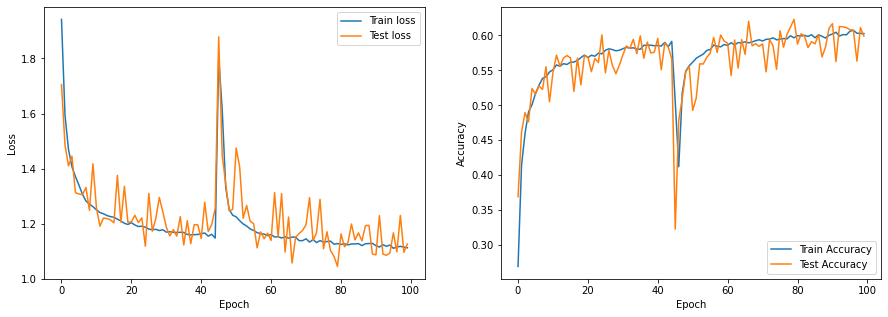

In [43]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(train_accs, label="Train Accuracy")
ax2.plot(test_accs, label="Test Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.savefig("metrics.png")
plt.show()

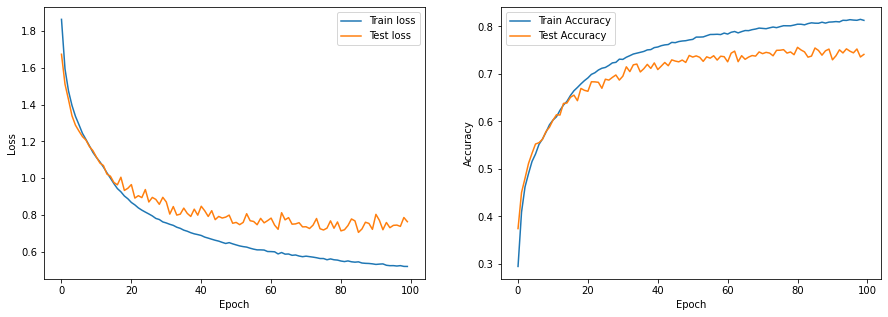

In [62]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(train_accs, label="Train Accuracy")
ax2.plot(test_accs, label="Test Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.savefig("metrics.png")
plt.show()